# 👗 EXP10. CIFAR-10 이미지 생성하기


* 이번 시간에는, GAN이라는 모델의 특징을 FASHION-MNIST 데이터셋을 가져와 알아보았습니다. 기존에 하던 모델과는 다르게, GAN에는 생성자와 판별자 두 모델을 만들어 줘야 했고, 이 모델들을 대립시켜 좋은 결과를 내게 한다라는 특징이 있었습니다. 


* 이번 시간에 배운 내용을 토대로, CIFAR-10 데이터셋을 가져와, GAN 모델을 생성한 다음,이미지를 생성해 보겠습니다. 또한 생성된 이미지를 보고 문제점을 찾아 모델을 개량해 보는 작업도 시도 해보겠습니다. 



---



# FASHION-MNIST 와 다른 점 
다른 점을 알아봅니다. 모델 제작 및 프로젝트 진행 시 참고합시다! 


* 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다.   
  **생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향**이 있습니다.


* 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다.   
  **시각화 과정에서 고려할 점**이 있습니다.


* **입력데이터 전체 차원이 3~4배 증가**하면서, 학습이 진행되는 양상이 다소 달라집니다. 



---



# 루브릭 평가 기준


| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다. | 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다. |
| 2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다. | gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다. |
| 3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다. | 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다. |



---




# 목차 

## 1. 작업환경 구성하기

## 2. 데이터셋 구성하기 

## 3. 생성자 구현하기

## 4. 판별자 구현하기

## 5. 손실함수와 최적화 함수 구현하기 

## 6. 훈련과정 상세 기능 구현하기 

## 7. 학습 과정 진행하기

## 8. GAN 훈련 과정 개선하기 

## 회고!

## 🖇️참고 페이지 



-----




# 1. 작업환경 구성하기

## &nbsp;&nbsp; 1-1. 필요 모듈 설치 & 작업환경 구성

* 필요한 라이브러리 설치 및 작업환경을 구성합니다. 
* gif 파일 생성 모듈과, 이미지 처리용 모듈이 필요합니다. 
* lms 진행 시 클라우드에 설치된 부분이지만 다시한번 확인 해 봅니다.
* 작업 환경은 dataset을 다른것을 사용하므로, 폴더를 다시 만들어줍니다. 

In [101]:
# cell에서 한 부분이므로, 주석처리 합니다. 
# # 설치 여부 확인 
# $ pip list | grep -E 'imageio|Pillow'

# # 없다면 설치하기
# $ pip install imageio #gif 파일 생성 모듈 
# $ pip install Pillow # 이미지 처리 모듈

# # 작업환경을 구성합니다. 

# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

## &nbsp;&nbsp; 1-2. 필요 라이브러리 불러오기

In [1]:
import os, glob, time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline



----



# 2. 데이터셋 구성하기 

* 이번 모델은 분류 문제가 아니기 때문에 라벨(y_train, y_test)이 필요 없습니다. 
* 가져올 데이터셋에 대해 알아보고, 데이터셋을 불러와 확인 해보고 학습용 데이터셋을 만드는 과정을 해보겠습니다. 

1. 데이터셋 뜯어보기  - 데이터셋의 특징 나열 
2. 데이터셋 불러와서 데이터 확인 해 보기 
3. 데이터셋에 필요한 조치 취하기 (정규화, 채널 추가 등) 

## &nbsp;&nbsp; 2-1 데이터셋 뜯어보기 


* 우선, 우리가 가져올 데이터셋의 특징을 알아봅시다. [The CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)  


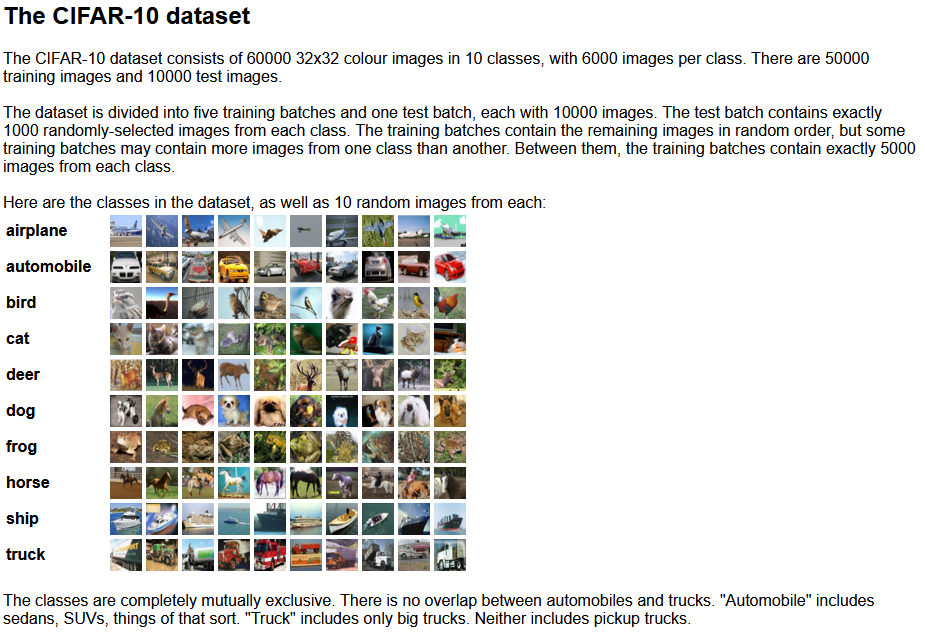  


* CIFAR-10 dataset
    1. 데이터 크기 : 60,000장 (train 50,000장, test 10,000장)
    2. 이미지 카테고리(feature) : 10개 (airplane, automobile, bird, … ,ship, truck)		
    3. 이미지의 shape : 32X32, 3채널(RGB) ```(32, 32, 3)```


* CIFAT-100이랑은 다른건가?   
> 비슷하지만, feature가 100개이고, 각 feature 마다 600 장의 이미지(Train 500, test 100)가 포함되어있다는 다른점이 있다. 특징의 분류가 대분류, 소분류로 세분화 되어있다. (superclass, classes) 


## &nbsp;&nbsp; 2-2 데이터셋 불러오기


* 어떤 데이터셋인지 알아봤으니, 데이터셋을 불러와 데이터를 확인 해봅시다.
* 또, 데이터를 알맞게 전처리 해 보고, 전처리 과정이 잘 이루어졌나 시각화 해 알아봅시다. 

In [2]:
# 데이터셋 구성하기 

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
# 픽셀 크기를 확인 해봅니다. 
# CIFAR-10 데이터의 픽셀 크기는 0~255 사이의 정수값인것을 알 수 있다. 
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


## &nbsp;&nbsp; 2-3 데이터 정규화

* 각 픽셀을 -1, 1 로 정규화시켜서 사용할 예정이므로, **중간값을 0으로 맞춰주기 위해** 127.5를 뺀 후, 127.5로 나눠줍니다.

In [7]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [8]:
# train data의 shape를 확인 해봅니다. 
train_x.shape


(50000, 32, 32, 3)

* ```train_x.shape```로 데이터를 확인 해 봤다. channel수에 3 이라 표시되어 있는 걸 보니, 채널 추가 작업은 구지 필요없을 것 같다.


## &nbsp;&nbsp; 2-4 데이터 시각화 


* 정규화된 데이터를 가져와 시각화 해서 확인 해 보겠습니다. 


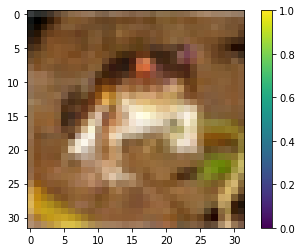

In [9]:
# 한장만 가져와서 확인해볼까요? 
plt.imshow((train_x[0]+ 1)/2)
plt.colorbar()
plt.show()

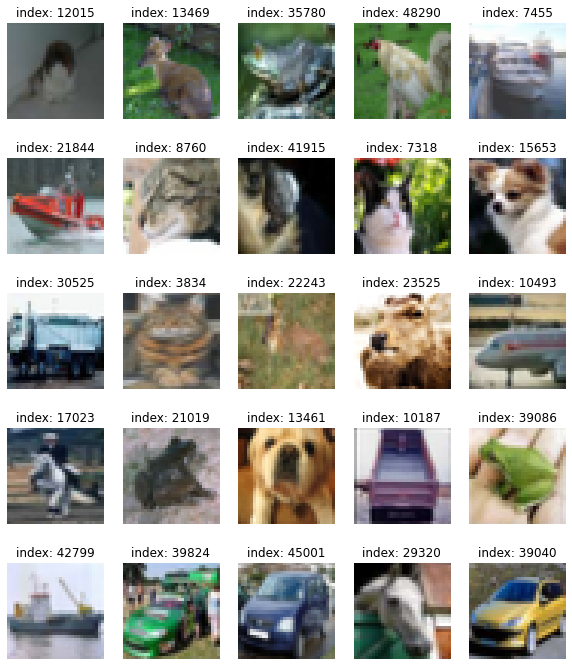

In [10]:
# 무작위로 25장만 가져와봅시다 
# 5*5 배열로 가져와 볼게요! 
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index] + 1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')
    
plt.show()

* lms 노드 그대로 했을 땐, ```Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). ``` 라는 오류 메세지가 출력됬었는데, 참고페이지의 방법대로 하니 문제없이 출력되었다. 
* train_x 의 0번째 이미지에 1을 더해 2로 나눠줬는데, 2-3에서 했던 데이터 정규화 과정과 일치한다. 오류 메세지에서 얘기하길, 0에서1이나 0에서255사이의 범위를 지정해 달라고 했으니, 더하고 나눠주는 정규화 과정을 통해 0~1 사이의 값으로 범위를 지정해 줬기 때문에 오류 없이 이미지가 출력되었다. 

## &nbsp;&nbsp; 2-5 배치사이즈, 버퍼사이즈 지정하기 

In [11]:
# 전체 데이터를 섞기 위해. 설정해 둠. shuffle() 함수로 데이터셋을 섞어 모델에 넣을것
BUFFER_SIZE = 60000

# 모델이 한 번에 학습할 데이터의 양 
# ndivia_smi 를 켜서 확인 해보고, 값을 조절 해 봅시다:D 
BATCH_SIZE = 256

## &nbsp;&nbsp; 2-6 학습용 데이터셋 만들기 


* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성합니다. 
- train_x 라는 넘파이 배열형 자료를 섞고, 이를 배치 사이즈에 따라 나누게 합니다. 
- 데이터가 잘 섞이게 하기 위해선 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print('학습용 데이터셋! 완료! ')

학습용 데이터셋! 완료! 




----




# 3. 생성자 구현하기


* GAN 네트워크에서 생성자 모델은 
    1. 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를생성해 냅니다. 
    2. 즉, 무에서 유를 창조하는 역할을 함. 
    
    
### 주의사항!  

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여  
  방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다. 

## &nbsp;&nbsp; 3-1 생성자 모델 구현 함수 만들기 

In [15]:
# 모델을 구현하는 함수 
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

## &nbsp;&nbsp; 3-2 생성자 모델을 구현하고, summary를 출력

In [16]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

* ```Conv2DTranspose``` 
    -> 이미지 사이즈를 넓혀주는 층으로, (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 키워나간다 합니다. 
    * 우리가 원하는 값은 32,32 이므로, ```7*7*256``` , ```Reshape((7, 7, 256))``` 부분을 8, 8  로 바꿔줍니다. 
    
* [```layers.Conv2DTranspose ```](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)   
 디컨볼루전 레이어. 이의 인수 값 중, 첫번째 값은 filters
 * 정수, 출력 공간의 차원 (즉, 컨볼루션의 출력 필터 수). 
 * CIFAR-10의 차원은 3차원 이기때문에, 1 을 3으로 변경해 주어야 한다. 


* 위와같이 변경 한 후, summary를 확인 해 보면 (32, 32, 3) shape의 모델로 생성된 것을 확인할 수 있다. 

## &nbsp;&nbsp; 3-3 노이즈 만들기 


* 이미지 형상을 만들어낼 때 필요한 노이즈를 ```tf.random.normal```를 이용해 만들어줍니다. 가우시안 분포에서 뽑아낸 랜덤 백터로 이루어진 노이즈 벡터를 만들어 주는 함수입니다. 
* 모델에 노이즈벡터를 넣어 shape를 확인 해 보고, 생성된 이미지를 시각화 해보겠습니다. 

In [17]:
# 노이즈 벡터 생성 

noise = tf.random.normal([1, 100])

In [18]:
# 제너레이터 모델에 노이즈 벡터를 넣어, 생성된 노이즈 벡터의 shape를 확인 
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

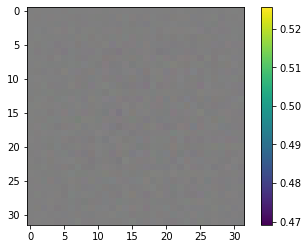

In [19]:
# 노이즈 이미지 시각화! 
plt.imshow((generated_image[0]+1)/2)
plt.colorbar()
plt.show()

* 학습이 되지 않아, 아무 의미 없는 노이즈 이미지로 생성됩니다. 
* 노이즈 이미지 생성 완료~! 



----




# 4. 판별자 구현하기

* GAN 네트워크에서 판별자 모델은 
    1. 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가
    **Real** 인지, **Fake** 인지에 대한 판단 정도를 실숫값으로 출력합니다.
    2. Fake와 Real이 그래프상에서 가까울 수록 잘 만든 모델.
    3. 위조지폐.. 진짜 돈이랑 위조한 돈을 놓고 비교했을때 위조돈이 진짜 돈 만큼 정교하게 복사되었다 == 학습이 잘 된 모델!, 판별자는 속았어요 

## &nbsp;&nbsp; 4-1 판별자 모델 구현하는 함수 만들기 

In [31]:
# 판별자 모델을 구현 해 봅시다! 
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model



- 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여 나갑니다. 
    - ex) `(28, 28, 1) → (14, 14, 64) → (7, 7, 128)`
    - 생성자에서 `32, 32, 3` 형태로 키워나갔으니, 판별자에서도 같은 형태로 시작해서 줄여 나가야할 것이다. 그렇기 때문에 input_shape = `28, 28, 1` -> `32, 32, 3` 으로 변경
    
    

- Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환
    - 판별자의 Reshape층에서 3차원 벡터를 1차원으로 변환하는 역할을 함.
    - 1차원 벡터로 변환 한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력함.

## &nbsp;&nbsp; 4-2 판별자 모델을 구현하고, summary를 출력

In [32]:
# discriminator 라는 이름으로 모델을 생성
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [33]:
# 위에서 생성했던 fake image를 넣어보면?
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00213638]], dtype=float32)>



----




# 5. 손실함수와 최적화 함수 구현하기 


- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다. 

## &nbsp;&nbsp; 5-1 손실 함수 구현하기 


* 생성자와 판별자의 손실함수를 구현해 봅니다. 
- Real Image에 대한 라벨을 `1`, Fake Image에 대한 라벨을 `0`으로 두었을 때,
    - 생성자
        - 판별자가 Fake Image에 대해 판별한 값.
        - **fake_image 값이 1에 가까워 지는 것이 목표.**
    - 판별자
        - Real Image의 판별값.
        - **real_image는 1에, fake_image는 0에 가까워지는 것을 목표**.
로 합니다. 

* 손실 함수로는 교차 엔트로피 (Cross Entropy)를 사용합니다. 
    - 분류 모델을 설계할 때 많이 사용했던 손실함수로, 2개 클래스 간의 분류문제를 풀 때 사용하는 손실함수 입니다. 

### &nbsp;&nbsp;&nbsp;&nbsp; 5-1-1 교차 엔트로피 함수 구현하기 


- `tf.keras.losses` 라이브러리 안에 있음.
- 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값.
    - 위 모델의 맨 마지막 Layer엔 활성화 함수가 따로 없었음.
    - ⇒ 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실수값을 가질 수 있다.
- `tf.keras.losses`의 `BinaryCrossEntropy`
    - 본인에게 들어오는 인풋값이 0 - 1 사이에 분포하는 확률값이라고 가정해줌.
    - 따라서, from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 
    함수 내부에서 sigmoid 함수를 사용해 0 ~ 1 사이의 값으로 정규화 한 후 알맞게 계산.


In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### &nbsp;&nbsp;&nbsp;&nbsp; 5-1-2 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현하기 


* `fake_output`와 `real_output`는 Cross_entropy를 활용해 계산할 loss들 입니다.
    - `fake_output`
        - 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값
    - `real_output`
        - 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값


* 계산할 loss 들은 0 or 1로 비교해야하는데, 이때 `tf.zeros_like()` , `tf.ones_like()` 함수를 사용해서 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 생성합니다. 

In [21]:
# generator_loss
# fake_output이 1에 가까울수록 작은 값을 가짐.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [34]:
# discriminator_loss
# real_output는 1로 채워진 벡터와, fake_output 는 0로 채워진 벡터와 비교함.
# discriminator_loss 값은 이 둘을 더한 값이다. 

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [35]:
# discriminator accuracy 
# 판별자가 real output, fake output 을 얼마나 정확히 판별하는지 계산한 accuracy 
# 둘 다 0.5에 가까워지는 것이 이상적인 수치. 

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy


## &nbsp;&nbsp; 5-2 최적화 함수 구현하기 


* 생성자와 판별자를 최적화하는 optimize를 정의합니다. 
* 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에,   
  optimizer도 따로 만들어줘야합니다. 
* learning rate는 2e-4 로 설정합니다. 결과값을 보고, 추후에 조정합니다. 
* 학습이 매번 어떻게 진행되 가는지 생성자가 생성한 샘플을 통해 알아봅니다. 

In [44]:
#optimizer 생성 
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [45]:
# 학습이 매번 어떻게 진행되어가는지 생성자가 생성한 샘플을 통해 알아봅니다.

noise_dim = 100
num_examples_to_generate = 16 # 1번에 생성하는 이미지 샘플 수  
# 100차원의 노이즈를 총 16개 형상의 벡터로 만듬 

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])



----



# 6. 훈련과정 상세 기능 구현하기


* 훈련 과정을 설계합니다. 이번 파트에서 해야할 것은 
    - 하나의 미니 배치 당 진행할 train_step 함수를 먼저 만든다.
    - 일정 간격으로 학습 현황을 볼 수 있게하는 함수를 만듭니다.
    - 한 epoch가 끝날때 마다 loss와 accuracy 시각화 그래프를 그리는 함수도 만듭니다. 
    - checkpoint를 만듭니다. 매번 모델을 직접 저장해주지 않아도, 코드 한줄로   
      버전 관리를 할 수 있어 편리합니다! 
    

## &nbsp;&nbsp; 6-1 train_step 함수 만들기  

* 데이터를 입력, 판별하고 loss와 accuracy, gradient를 계산하고 모델을 학습하는 기능이 있는 함수입니다. 

* 학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙여서 사용합니다.
    - 데코레이터가 사용된 함수에 입력된 입력은 ensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환 됩니다. 

In [38]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

## &nbsp;&nbsp; 6-2 일정 간격으로 학습 현황을 확인하는 함수 만들기 


* 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인 할 수 있다. 
- 모델이 16개의 seed가 들어있는 sample_seed를 입력받아서 만들어낸 prediction을 시각화 해주는 과정입니다. 
- `plt`에 저장되어 보이는 이미지를 `plt.savefig`로 간단히 파일로 저장합니다.

In [39]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    predictions = (predictions + 1)/2
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_case2_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

## &nbsp;&nbsp; 6-3 한 epoch가 끝날때 마다 loss와 accuracy 시각화 그래프를 그리는 함수 만들기 


- `train_step()` 함수가 리턴하는 `gen_loss`, `disc_loss`, `real_accuracy`, `fake_accuracy` 이 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 
  매 epoch마다 시각화하는 함수입니다. 
- 생성자의 loss의 history는 `history['gen_loss']`로 접근할 수 있는 list로 관리합니다.

In [40]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_case2_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

## &nbsp;&nbsp; 6-4 checkpoint 만들기 


- `tf.train.Checkpoint` 로 checkpoint를 만듭니다. 
    - 매번 모델을 직접 저장해 주지 않아도 코드 한 줄로 버전 관리를 할 수 있음.
    - 모델이 복잡해지고 학습 속도가 오래 걸릴수록 모델에 대한 저장 및 버전 관리는 필수!
    
    
- checkpoint 모델을 저장하기 위해 작업환경 내에 `training_checkpoints` 라는 디렉토리를 사용합니다. 
- checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장함.
    - 생성자와 판별자가 학습한 모델 가중치를 저장하는것.
    - = 게임의 체크포인트 처럼 우리의 학습 환경과 학습한 내용을 저장.

In [41]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_case2")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## &nbsp;&nbsp; 6-5 위 과정을 하나의 함수로 합쳐주기!


* 함수의 입력값으로 받을 인자들은 아래와 같습니다.
- `dataset`
    - 학습에 쓸 데이터 셋
- `epochs`
    - 전체 학습 에포크를 결정
- `save_every`
    - 모델을 저장하는 간격을 담당

In [42]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

## &nbsp;&nbsp; 6-6 사용가능한 GPU 디바이스를 확인.


* 이미지 데이터셋이기 때문에, CPU를 사용하게되면 몹시 느려서, GPU를 사용해야합니다.  
  그렇기 때문에 학습 진행하기 전에 먼저 사용가능한 GPU 디바이스를 확인합니다. 

In [43]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



----




# 7. 학습 과정 진행하기


* 6번 과정에서 만든 훈련 과정과, 5번 과정에서 만든 모델을 가져와 본격적으로 이미지 생성 모델을 훈련시킵니다. 

* epoch 수 만큼 학습이 끝났다면, 생성햇던 샘플 이미지들을 합쳐 GIF 파일로 만들어서 학습 과정을 저장합니다. 

* 결과물을 확인 해보고, 문제점을 파악해 모델을 개선 해봅시다. 

## &nbsp;&nbsp; 7-1 모델 학습 진행하기


* 코드를 실행하면, 모델이 학습 해 나가면서 만들어내는 결과물을 실시간으로 확인할 수 있습니다. 

* 우선 50번의 epoch를 실행하여 학습 해 보겠습니다.

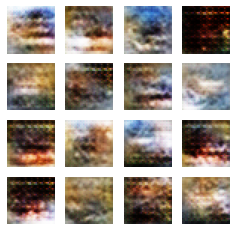

Time for training : 749 sec


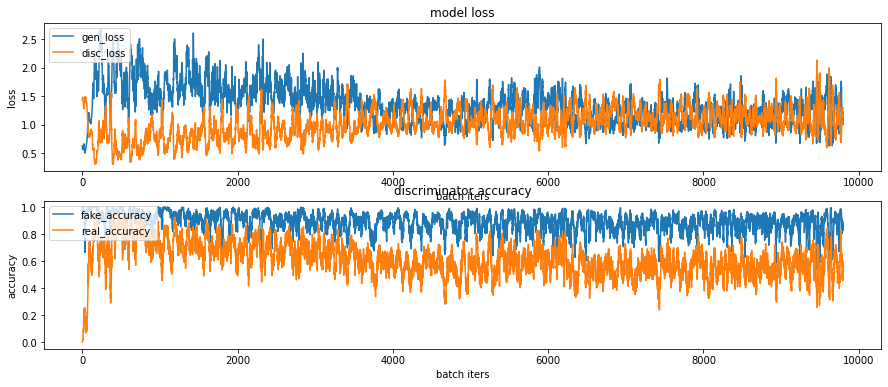

CPU times: user 12min 52s, sys: 1min 17s, total: 14min 9s
Wall time: 12min 30s


In [131]:
# %%time
# train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.




-----





# 8. GAN 훈련 과정 개선하기 


* 개선 전에 checkpoint로 저장한 모델을 불러옵니다.
* checkpoint 모듈을 이용해 저장된 모델을 불러온다면, 모델의 재학습이 필요없이 이어서 모델을 학습시켜줄 수 있습니다! (편하네요!) 

## &nbsp;&nbsp; 8-1  checkpoint 모듈을 활용하여 모델을 로드! 

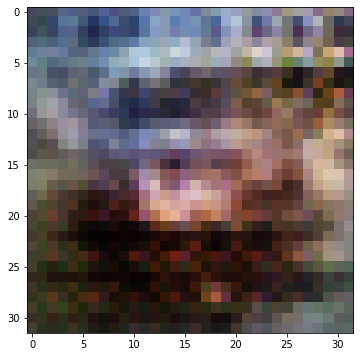

In [46]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## &nbsp;&nbsp; 8-2 GAN 훈련과정 개선 - epoch 300,  learning rate 2e-4 

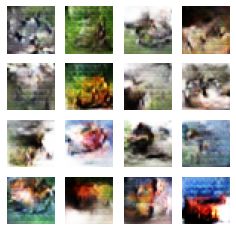

Time for training : 4736 sec


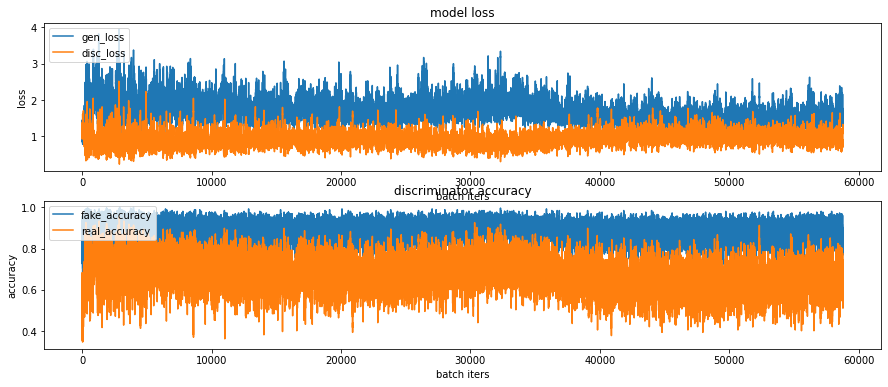

In [47]:
EPOCHS = 300

train(train_dataset, EPOCHS, save_every)

In [48]:
# 샘플 이미지 시각화 

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_case02.gif' # gif로 저장할 파일 디렉토리 & 파일명 

with imageio.get_writer(anim_file, mode='I') as writer:
    # cifar10/generated_samples/sample*.png # 이게 지금 생성된 이미지면 
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_case2*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


In [49]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_case02_graph.gif'

with imageio.get_writer(anim_file, mode='I') as writer: #
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_case2*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames) # 그리고 train* 로  png 파일 
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# 회고!

# 🖇️참고 페이지 

### 데이터 시각화 - 흑백 이미지로 나왔던 부분 해결방법 참고 

* [강양인 유현지님 프로젝트](https://github.com/hyyoo3526/AIFFEL_EXPLORATION/blob/main/EXPLORATION_13/EXPLORATION_IC1_13_dcgan_newimage.ipynb)

* [강양인 정우일님 프로젝트](https://github.com/jungwooil/aiffel/blob/master/LMS/EXPLORATION/13_dcgan_newimage/13_dcgan_newimage.ipynb)